In [2]:
import os 
from pathlib import Path
import torch
from transformers import *
import csv
import numpy as np
import matplotlib.pyplot as plt
ADD_GAPS = False

In [3]:
import pandas as pd
ADD_BLANK = False
def gen_wordlist(len_wordlist=60, add_blank = ADD_BLANK):
    """Generates wordlist as opposed to sentences in the Ding data.

    output structure:    "w1 w2 w3 w4."
    """
    full_ding = pd.read_csv(str(Path(os.getcwd()).parent) + '\\Data\\Ding_grammatical.csv',
                           header=None)
    # get all nouns
    nouns = pd.unique(pd.concat([full_ding[1],full_ding[3]]))
    # get all adjectives
    adjectives = pd.unique(full_ding[0])
    # get all verbs
    verbs = pd.unique(full_ding[2])
    all_words = np.unique(np.concatenate([nouns,adjectives,verbs]))
    # get word salad
    word_salad_seqs = []
    for i in range(60):
        word_salad = np.random.choice(all_words,size=4,replace=False)
        word_salad_seq = ' '.join(word_salad)
        #if add_blank:
        #    word_salad_seq = word_salad_seq + '.'
        word_salad_seqs.append(word_salad_seq)
    # get jabberwocky
    jabberwocky_seqs = []
    for i in range(60):
        jabberwocky = np.random.choice(adjectives,size=1) + ' ' + np.random.choice(nouns,size=1) + ' ' + \
            np.random.choice(verbs,size=1) + ' ' + np.random.choice(nouns,size=1)
        #if add_blank:
        #    jabberwocky = jabberwocky + '.'
        jabberwocky_seqs.append(list(jabberwocky))
    jabberwocky_seqs = [i[0] for i in jabberwocky_seqs]
    # get noun phrases
    np_seqs = []
    for i in range(60):
        np_seq = np.random.choice(adjectives,size=1) + ' ' + np.random.choice(nouns,size=1) + ' ' + \
            np.random.choice(adjectives,size=1) + ' ' + np.random.choice(nouns,size=1)
        #if add_blank:
        #    np_seq = np_seq + '.'
        np_seqs.append(list(np_seq))
    np_seqs = [i[0] for i in np_seqs]
    # get verb phrases
    vp_seqs = []
    for i in range(60):
        vp_seq = np.random.choice(verbs,size=1) + ' ' + np.random.choice(nouns,size=1) + ' ' + \
            np.random.choice(verbs,size=1) + ' ' + np.random.choice(nouns,size=1) 
        #if add_blank:
        #    vp_seq = vp_seq + '.'
        vp_seqs.append(list(vp_seq))
    vp_seqs = [i[0] for i in vp_seqs]
    # get random pattern - say - verb, noun, noun, adjective
    random_patterns = []
    for i in range(60):
        random_pattern = np.random.choice(verbs,size=1) + ' ' + np.random.choice(nouns,size=1) + ' ' + \
            np.random.choice(nouns,size=1) + ' ' + np.random.choice(adjectives,size=1) 
        #if add_blank:
        #    random_pattern = random_pattern + '.'
        random_patterns.append(list(random_pattern))
    random_patterns = [i[0] for i in random_patterns]

    return [word_salad_seqs,jabberwocky_seqs,np_seqs,vp_seqs,random_patterns]

In [4]:
# read sentences : 
sentences = []
with open(str(Path(os.getcwd()).parent) + '\\Data\\Ding_grammatical.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        #if ADD_BLANK:
        #    sentences.append(' '.join(row) + '.')
        #else:
        sentences.append(' '.join(row))        
            

sentences = ' '.join(sentences)
sentences = sentences.split()

sjnv = gen_wordlist()
sjnv = [subitem for sublist in sjnv for subitem in sublist]
sjnv = ' '.join(sjnv)
sjnv = sjnv.split()
sjnv = sentences + sjnv
# sentences_all = sentences, sjnv[0:240] (word salad), sjnv[240:480] (jabberwocky), sjnv[480:720] (np), sjnv[720:960] (vp), sjnv[960:](random pattern) 

# add blank if ADD_BLANK is True
if ADD_BLANK:
    temp = []
    for i in range(len(sjnv)+1):
        if i%4 == 0:
            temp.append(sjnv[i-4:i] + ['.'])
    temp.pop(0)
    sjnv = temp
    sjnv = [word for sublist in sjnv for word in sublist]

if ADD_GAPS:
    temp = sjnv
    for ind,t in enumerate(temp):
        temp[ind] = temp[ind] + ' - - - -'
        temp[ind] = temp[ind].split(' ')
    temp = [t for tem in temp for t in tem]
    sjnv = temp

plot_names = {'valid_sentences':'Valid Sentences',
             'word_salad':'Word Salad',
             'jabberwocky': 'Jabberwocky',
             'noun_phrases':'Noun Phrases',
             'verb_phrases':'Verb Phrases',
             'random_pattern':'Random Pattern (v-n-n-a)'}
stimuli = ['valid_sentences','word_salad','jabberwocky','noun_phrases','verb_phrases','random_pattern']

In [7]:
def windowed_zscores(vals,window=10):
    scores = np.zeros(vals.shape)
    seq_length = vals.shape[0]
    for i in range(seq_length):
        # before window length is reached
        if i < window:
            scores[i] = vals[i] - np.concatenate([vals[i+1:i+1+window],vals[0:i]]).mean()
        # less than window length remaining
        elif (i + window) > seq_length:
            scores[i] = vals[i] - np.concatenate([vals[i-window:i],vals[i+1:]]).mean()
        # after window length is reached
        else:
            scores[i] = vals[i] - np.concatenate([vals[i+1:i+1+window],vals[i-window:i]]).mean()
    return scores

In [8]:
# power spectra function
def power_spectra(w2vec_array, sampling_rate=16):
    """Computes power spectra using the Discrete Fourier Transform.

    Args:
        w2vec_array: arrays of shape (n_sentences*time_steps, n_units)
            representing hidden layer activations in response to each word of the
            concatenated sequence of sentences.
        sample_rate: number of measures (outputs of the model) per second.

    Returns:
        Mean power spectra and frequency axis.
    """

    # Separate each unit and concatenate across words to form 1 vector per unit
    unit_vectors = np.transpose(w2vec_array)

    # Frequency domain
    # num_samples is just the number of data points for each unit
    num_samples = unit_vectors.shape[1]
    freq = np.fft.rfftfreq(num_samples, d=1./sampling_rate)
    #print ('freq ' ,freq.shape)
    # Calculate the FFT and power spectra for each unit
    units_ps = []
    for vector in unit_vectors:
        ft_unit = np.fft.rfft(vector)  # fft
        ps_uni = np.abs(ft_unit) ** 2  # power spectrum
        units_ps.append(ps_uni)

    # Average power spectra over units
    units_ps = np.array(units_ps)
    mean_ps = np.mean(units_ps, axis=0)
    #print ('mean_ps',mean_ps.shape)
    return freq, mean_ps, units_ps

In [9]:
def plot_results(plot_name, freq, power, act,sampling_rate=16,n_samples=60,title='Input stimuli'):
    """Plot all the results of one condition"""
    plt.rcParams['pdf.fonttype'] = 42 # for the eps files
    plt.rcParams['ps.fonttype'] = 42

    # Time domain parameters
    sampling_interval = 1.0/sampling_rate  # sampling interval
    t = np.arange(0, len(act))  # time vector
    # Build plot
    fig, ax = plt.subplots(nrows=2, ncols=1)
    fig.suptitle(title)
    ax[0].plot(t, act, linewidth=1.0)
    # Axis labels
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Amplitude')
    #until_4 = np.where(freq==4)[0][0]
    #print('Power difference ')
    ax[1].plot(freq[1:], power[1:], 'r', linewidth=1.0)
    ax[1].set_xlabel('Freq (Hz)')
    ax[1].set_ylabel('Power')
    # Adjusts subplot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Save
    fig.savefig(plot_name+'.pdf',format='pdf')


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',add_special_tokens=False)
model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states=True,
                                        output_attentions=False)

7200

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Input tensor shape :  torch.Size([1, 242])
Hidden state shape :  torch.Size([1, 242, 768])


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Input tensor shape :  torch.Size([1, 242])
Hidden state shape :  torch.Size([1, 242, 768])


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Input tensor shape :  torch.Size([1, 242])
Hidden state shape :  torch.Size([1, 242, 768])


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Input tensor shape :  torch.Size([1, 242])
Hidden state shape :  torch.Size([1, 242, 768])


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Input tensor shape :  torch.Size([1, 242])
Hidden state shape :  torch.Size([1, 242, 768])


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Input tensor shape :  torch.Size([1, 242])
Hidden state shape :  torch.Size([1, 242, 768])


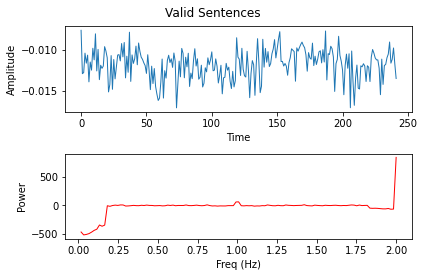

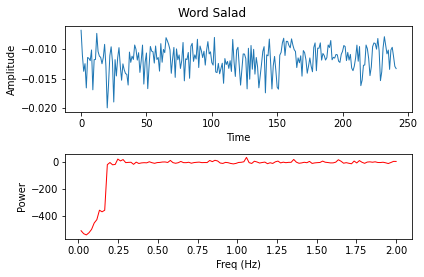

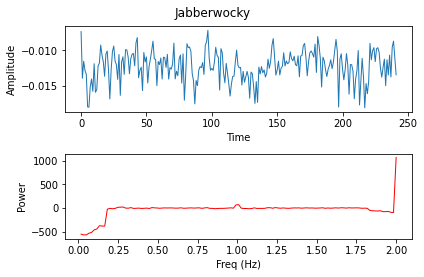

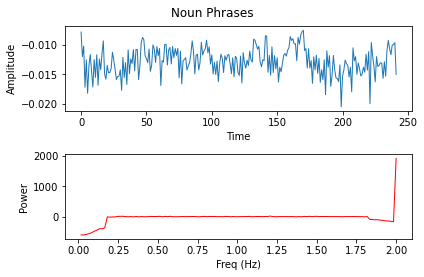

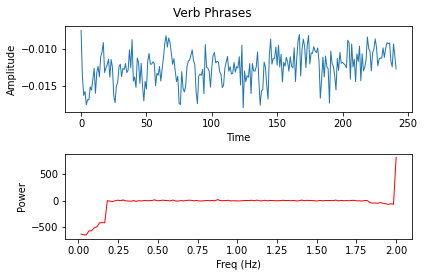

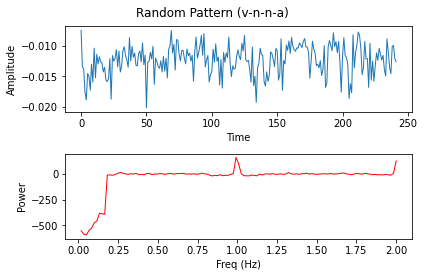

In [15]:
for i in range(0,6):
    if ADD_BLANK:
        sentences_all = sjnv[i*300:(i+1)*300]
    elif ADD_GAPS:
        sentences_all = sjnv[i*1200:(i+1)*1200] # 1200 tokens per run = 60 * 20
    else:
        sentences_all = sjnv[i*240:(i+1)*240]
    
    # if tokenizer.encode is provided a list of words as input, the input_ids shape is consitent across conditions
    # else, the pretrained tokenizer chunks up the data, resulting in incosistent input_ids shape
    
    data_names = ['freq','mean_power','activations']
    
    input_ids = torch.tensor([tokenizer.encode(sentences_all,max_length=512,truncation=False)])
    print('Input tensor shape : ',input_ids.shape)
    output_ids = tokenizer.decode(input_ids[0])
    with torch.no_grad():
        last_hidden_states = model(input_ids)[0]# Models outputs are now tuples
    print('Hidden state shape : ',last_hidden_states.shape)
    temp_acts = last_hidden_states[0,:,:].numpy()
    if ADD_BLANK:
        freq, mean_power = power_spectra(temp_acts,sampling_rate=5)
        mean_power = windowed_zscores(mean_power,window=10)
        plot_results(str(Path(os.getcwd()).parent) + '\\Data\\plots-bert-smoothed-blank\\' + stimuli[i],  
             freq, mean_power, act=np.mean(temp_acts,axis=1),
             sampling_rate=5,n_samples=60,title=plot_names[stimuli[i]])
    elif ADD_GAPS:
        freq, mean_power, unit_ps = power_spectra(temp_acts,sampling_rate=20)
        mean_power = windowed_zscores(mean_power,window=10)
        # store freq and mean_power and activations
        paths = str(Path(os.getcwd()).parent) + '\\Data\\data-vals-gaps\\' + stimuli[i] + '\\'
        np.save(paths + 'freq.npy',freq)
        np.save(paths + 'unit_power.npy',unit_ps)
        np.save(paths + 'activations.npy',temp_acts)
        plot_results(str(Path(os.getcwd()).parent) + '\\Data\\plots-bert-gaps\\' + stimuli[i],  
             freq, mean_power, act=np.mean(temp_acts,axis=1),
             sampling_rate=20,n_samples=60,title=plot_names[stimuli[i]])        
    
    else:
        freq, mean_power, unit_ps = power_spectra(temp_acts,sampling_rate=4)
        mean_power = windowed_zscores(mean_power,window=10)
        # store freq and mean_power and activations
        paths = str(Path(os.getcwd()).parent) + '\\Data\\data-vals\\' + stimuli[i] + '\\'
        np.save(paths + 'freq.npy',freq)
        np.save(paths + 'mean_power.npy',mean_power)
        np.save(paths + 'activations.npy',temp_acts)
        plot_results(str(Path(os.getcwd()).parent) + '\\Data\\plots-bert-smoothed\\' + stimuli[i],  
             freq, mean_power, act=np.mean(temp_acts,axis=1),
             sampling_rate=4,n_samples=60,title=plot_names[stimuli[i]])


In [13]:
temp = power_spectra(temp_acts,sampling_rate=4)

In [14]:
len(temp)

3